In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import pandas as pd
import numpy as np
from util_functions import process_files, decide_class, get_class_label, plot_confusion_matrix

Using TensorFlow backend.


In [3]:
# PREDICTIONS FROM SAVED MODEL
from keras.models import model_from_json

model_name = 'sound_classifier'

# load json and create model
json_file = open('saved_models/' + model_name + '.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights('saved_models/' + model_name + '.h5')

In [4]:
# load the test data
x_test, y_test, f_test = process_files(dataset='test', features=['Mel', 'Mel_deltas'], shape='stacked')

# input image dimensions
input_d = x_test.shape[1] #Depth
input_h = x_test.shape[2] #Height
input_w = x_test.shape[3] #Width

#Reshaping to feed to network in the same shape as it was trained
x_test = x_test.reshape(x_test.shape[0], input_h, input_w, input_d)

# create predictions and select class from one-hot encoding
scores = loaded_model.predict(x_test)
classes = [np.argmax(s) for s in scores]

#Combine in a single dataframe
test_df = pd.DataFrame({'file_id': f_test,
                        'prediction': classes,
                        'ground_truth': y_test
                        })  

test_df = test_df.groupby(['file_id', 'ground_truth'], as_index=False)['prediction'].mean()
test_df['file_prediction'] = test_df.apply(lambda row: decide_class(row['prediction']), axis=1)

Classification Report

             precision    recall  f1-score   support

        cat       0.86      0.98      0.91        49
        dog       0.96      0.76      0.85        33

avg / total       0.90      0.89      0.89        82

Accuracy Score

0.890243902439


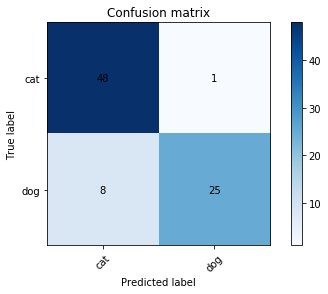

In [12]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

ground_truth = test_df['ground_truth'].tolist()
predictions = test_df['file_prediction'].tolist()

ground_truth_labels = [get_class_label(g) for g in ground_truth]
predictions_labels = [get_class_label(p) for p in predictions]
target_names = ['cat', 'dog']

#RESULTS:
print('Classification Report\n')
print(classification_report(ground_truth, predictions, target_names=target_names))

print('Accuracy Score\n')
print(accuracy_score(ground_truth, predictions))

confusion_matrix = confusion_matrix(ground_truth, predictions)
plot_confusion_matrix(confusion_matrix, target_names=target_names)